<a href="https://colab.research.google.com/github/dankrelium/Pos-Graduacao/blob/main/MVP_ML_e_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [76]:
#!pip install transformers
#!pip install fuzzywuzzy

In [149]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import sklearn as sk
import pandas as pd
from scipy.stats import f_oneway, chi2_contingency
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
#from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Conv1D, LSTM, Dense, Bidirectional, Dropout
#from keras.layers import LSTM
#from keras.layers import Dense
#from keras.layers import Bidirectional
#from keras.layers import Dropout
from keras import regularizers
from sklearn.metrics import confusion_matrix
import itertools

import re
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Modelo 1: Machine Learning Clássico

Para esta estapa foi escolhido um problema de regressão.

O dataset foi extraído do [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) e consiste em 1460 registros de imóveis vendidos em Ames (Iowa-EUA) com 81 atributos em cada registro, como tipo de imóvel, metragem quadrada, quantidade de quartos, etc, incluindo o valor de venda do imóvel, que será o target.


##**Análise e tratamento dos dados**



Os atributos foram analisados um a um de acordo com a descrição fornecida pelo Kaggle, e definidos de acordo com a seguinte lógica:

Numéricos ordinais: float.

Numéricos categóricos: object.

Categóricos: object.

Outro objetivo dessa análise foi identificar os atributos categóricos ordinais para posteriormente transformá-los em números de acordo com sua hierarquia.

In [78]:
# Definindo o dtype das colunas ao carregar o arquivo
dtype = {'MSSubClass': object, 'MSZoning': object, 'LotFrontage': float, 'LotArea':object, 'Street':object, 'Alley':object, 'LotShape':object,
         'LandContour':object, 'Utilities':object, 'LotConfig':object, 'LandSlope':object, 'Neighborhood':object, 'Condition1':object,
         'Condition2':object, 'BldgType':object, 'HouseStyle':object, 'OverallQual':float, 'OverallCond':float, 'YearBuilt':float,
         'YearRemodAdd':float, 'RoofStyle':object, 'RoofMatl':object, 'Exterior1st':object, 'Exterior2nd':object, 'MasVnrType':object,
         'MasVnrArea':float, 'ExterQual':object, 'ExterCond':object, 'Foundation':object, 'BsmtQual':object, 'BsmtCond':object,
         'BsmtExposure':object, 'BsmtFinType1':object, 'BsmtFinSF1':float, 'BsmtFinType2':object, 'BsmtFinSF2':float, 'BsmtUnfSF':float,
         'TotalBsmtSF':float, 'Heating':object, 'HeatingQC':object, 'CentralAir':object, 'Electrical':object, '1stFlrSF':float, '2ndFlrSF':float,
         'LowQualFinSF':float, 'GrLivArea':float, 'BsmtFullBath':float, 'BsmtHalfBath':float, 'FullBath':float, 'HalfBath':float, 'Bedroom':float,
         'Kitchen':float, 'KitchenQual':object, 'TotRmsAbvGrd':float, 'Functional':object, 'Fireplaces':float, 'FireplaceQu':object,
         'GarageType':object, 'GarageYrBlt':float, 'GarageFinish':object, 'GarageCars':float, 'GarageArea':float, 'GarageQual':object,
         'GarageCond':object, 'PavedDrive':object, 'WoodDeckSF':float, 'OpenPorchSF':float, 'EnclosedPorch':float, '3SsnPorch':float,
         'ScreenPorch':float, 'PoolArea':float, 'PoolQC':object, 'Fence':object, 'MiscFeature':object, 'MiscVal':float, 'MoSold':object,
         'YrSold':object, 'SaleType':object}

df = pd.read_csv('https://raw.githubusercontent.com/dankrelium/Pos-Graduacao/main/AI/data/real_state.csv', dtype=dtype)
#df = pd.read_csv('/content/drive/MyDrive/PÓS CD E IA/MVP ML e IA/train.csv', dtype=dtype)
df = df.drop(['Id'], axis=1) # Remoção de atributo irrelevante

Dos 13 atributos categóricos ordinais, 10 compartilham das mesmas categorias (Ex, Gd, TA, Fa, Po). Destas, 5 compartilham uma categoria extra (NA), em que:

Ex = Excellent

Gd = Good

TA = Typical

Fa = Fair

Po = Poor

NA = No ***Basement (or Garage, Pool, Fireplace...)***

Ou seja, estes atributos avaliam a qualidade de uma parte da casa, e 'NA' indica que a casa não possui tal parte.

Como veremos a seguir, não há valores 'NA' no dataframe, então assumiremos que estes constam como NAN (a análise do boxplot corroborou essa tese).

In [79]:
colunas_categoricas_ordinais = ['ExterQual', 'ExterCond', "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]

In [80]:
for coluna in df[colunas_categoricas_ordinais]:
    valores_unicos = df[coluna].unique()
    print(f"Valores únicos em {coluna}: {valores_unicos}")

Valores únicos em ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
Valores únicos em ExterCond: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
Valores únicos em BsmtQual: ['Gd' 'TA' 'Ex' nan 'Fa']
Valores únicos em BsmtCond: ['TA' 'Gd' nan 'Fa' 'Po']
Valores únicos em HeatingQC: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
Valores únicos em KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']
Valores únicos em FireplaceQu: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Valores únicos em GarageQual: ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
Valores únicos em GarageCond: ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
Valores únicos em PoolQC: [nan 'Ex' 'Fa' 'Gd']


In [81]:
nulos_por_coluna = df.isnull().sum()
nulos_por_coluna = nulos_por_coluna[nulos_por_coluna > 0]
print(nulos_por_coluna)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [82]:
# Substituindo os valores NaN por "NA" nas colunas categóricas
df[colunas_categoricas_ordinais] = df[colunas_categoricas_ordinais].fillna('NA')

Transformação das categorias ordinais em números:

In [83]:
# Mapear as substituições desejadas
substituicoes = {'Ex': 5,'Gd': 4,"TA": 3,"Fa": 2,"Po": 1,"NA": 0}
# Aplicar as substituições nas colunas especificadas
colunas_especificas = ['ExterQual', 'ExterCond', "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
df[colunas_especificas] = df[colunas_especificas].replace(substituicoes).astype(float)

Transformação das categorias ordinais com qualidades singulares em números:

In [84]:
df["LotShape"] = df["LotShape"].replace({'Reg':3,'IR1':2,"IR2": 1,"IR3": 0}).astype(float)
df["LandSlope"] = df["LandSlope"].replace({'Sev': 2,'Mod': 1,"Gtl": 0}).astype(float)
df["BsmtExposure"] = df["BsmtExposure"].replace({'Gd':4,'Av': 3,"Mn": 2, "No":1,"NA": 0}).astype(float)

Verificação dos valores nulos do dataset por coluna:

In [85]:
nulos_por_coluna = df.isnull().sum()
nulos_por_coluna = nulos_por_coluna[nulos_por_coluna > 0]
print(nulos_por_coluna)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
GarageType        81
GarageYrBlt       81
GarageFinish      81
Fence           1179
MiscFeature     1406
dtype: int64


Conferindo os index dos valores nulos dos atributos **MasVnrType** e **MasVnrArea**

In [86]:
df[df[["MasVnrType", "MasVnrArea"]].isnull().any(axis=1)].index

Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')

Os oito registros nulos de cada atributo correspondem aos mesmo 8 em ambos, então deletaremos os registros.

In [87]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Os mesmos critérios aplicados em **MasVnrType** e **MasVnrArea** também serão usados em **BsmtExposure**, **BsmtFinType1** e **BsmtFinType2**.

In [88]:
df[df[["BsmtExposure", "BsmtFinType1", "BsmtFinType2"]].isnull().any(axis=1)].index

Int64Index([  17,   39,   90,  102,  156,  182,  259,  332,  342,  362,  371,
             392,  520,  532,  533,  553,  646,  705,  736,  749,  778,  868,
             894,  897,  948,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090,
            1179, 1216, 1218, 1232, 1321, 1412],
           dtype='int64')

In [89]:
df = df.dropna(subset=["BsmtExposure", "BsmtFinType1", "BsmtFinType2"])

Deletando registro com **Electrical**, **GarageType**, **GarageYrBlt** e **GarageFinish** nulos:

In [90]:
df = df.dropna(subset=["Electrical", "GarageType", "GarageYrBlt", "GarageFinish"])

In [91]:
nulos_por_coluna = df.isnull().sum()
nulos_por_coluna = nulos_por_coluna[nulos_por_coluna > 0]
print(nulos_por_coluna)

LotFrontage     244
Alley          1257
Fence          1077
MiscFeature    1289
dtype: int64


Os quatro atributos com NAN que sobraram serão excluídos na etapa de feature selection pois possuem baixa correlação com o target, como veremos a seguir.

**Feature selection:**

Atributos numéricos:

Utilizaremos o método de cálculo da correlação de pearson. Serão incluídos atributos com correlação em valor absoluto maior que 0.4

In [92]:
corr_cut = 0.4
corr_matrix = df.corr()
corr_col1 = corr_matrix['SalePrice']
corr_cols_high = list(corr_col1[abs(corr_col1) > corr_cut].index) # Colunas com correlação maior que corr_cut
corr_cols_low = list(corr_col1[abs(corr_col1) <= corr_cut].index) # Colunas com correlação menor ou igual a corr_cut
corr_col1

LotFrontage      0.343978
LotShape        -0.261992
LandSlope        0.061629
OverallQual      0.783546
OverallCond     -0.108627
YearBuilt        0.504297
YearRemodAdd     0.501435
MasVnrArea       0.465811
ExterQual        0.669504
ExterCond       -0.014200
BsmtQual         0.643452
BsmtCond         0.141028
BsmtExposure     0.359809
BsmtFinSF1       0.359677
BsmtFinSF2      -0.031226
BsmtUnfSF        0.191689
TotalBsmtSF      0.602042
HeatingQC        0.416404
1stFlrSF         0.604714
2ndFlrSF         0.311354
LowQualFinSF    -0.009992
GrLivArea        0.711706
BsmtFullBath     0.209695
BsmtHalfBath    -0.030175
FullBath         0.569313
HalfBath         0.258175
BedroomAbvGr     0.169266
KitchenAbvGr    -0.111408
KitchenQual      0.650226
TotRmsAbvGrd     0.551821
Fireplaces       0.445434
FireplaceQu      0.497192
GarageYrBlt      0.481730
GarageCars       0.640154
GarageArea       0.607535
GarageQual       0.160960
GarageCond       0.121846
WoodDeckSF       0.305983
OpenPorchSF 

Atributos categóricos:

Utilizaremos o método de análise de variância (ANOVA). Serão incluídos atributos com valor maior que 30.

In [93]:
f_cut = 30
# Cria uma lista com as colunas cujo f_value é maior que 3
selected_categ_cols = []
for col in df.select_dtypes(include='object'):
    groups = df.groupby(col)['SalePrice'].apply(list)
    f_value, p_value = f_oneway(*groups)
    if f_value > f_cut:
        selected_categ_cols.append(col)
    print(f'{col}: F={f_value:.2f}, p-value={p_value:.3f}')

MSSubClass: F=26.52, p-value=0.000
MSZoning: F=38.84, p-value=0.000
LotArea: F=4.04, p-value=0.000
Street: F=2.37, p-value=0.124
Alley: F=26.14, p-value=0.000
LandContour: F=12.70, p-value=0.000
Utilities: F=0.39, p-value=0.533
LotConfig: F=6.85, p-value=0.000
Neighborhood: F=60.89, p-value=0.000
Condition1: F=5.08, p-value=0.000
Condition2: F=2.01, p-value=0.051
BldgType: F=8.74, p-value=0.000
HouseStyle: F=16.79, p-value=0.000
RoofStyle: F=17.00, p-value=0.000
RoofMatl: F=6.47, p-value=0.000
Exterior1st: F=19.49, p-value=0.000
Exterior2nd: F=17.08, p-value=0.000
MasVnrType: F=91.02, p-value=0.000
Foundation: F=104.68, p-value=0.000
BsmtFinType1: F=64.19, p-value=0.000
BsmtFinType2: F=3.54, p-value=0.003
Heating: F=1.54, p-value=0.204
CentralAir: F=55.53, p-value=0.000
Electrical: F=16.73, p-value=0.000
Functional: F=3.52, p-value=0.002
GarageType: F=67.01, p-value=0.000
GarageFinish: F=236.66, p-value=0.000
PavedDrive: F=22.83, p-value=0.000
Fence: F=4.07, p-value=0.008
MiscFeature: 

*(O texto a seguir escrevi para entender melhor como interpretar os resultados da ANOVA)*

**f_value** = variância das médias dos grupos / média das variâncias dentro dos grupos.

Quanto maior f_value maior a relação do atributo com a formação do preço, pois maior variância das médias dos grupos implica maior diferença de preço entre os grupos, ao passo que quanto menor a média das variâncias dentro dos grupos maior é a especificidade de preço em cada grupo.

Maximixando variância das médias dos grupos e minimizando média das variâncias dentro dos grupos, temos que f_value maiores são melhores.

**p-value** representa a probabilidade dos resultados terem acontecido por acaso, portanto quanto menor melhor.


**Obs.:** Na ANOVA dos dados, todos os atributos com **p-value > 0**  possuem  **f_value** pequeno.

Aplicando OneHotEncoder nos atributos categóricos:

In [94]:
# Criando o objeto OneHotEncoder
encoder = OneHotEncoder()

# Ajustando e transformando os dados
encoded_data = encoder.fit_transform(df[selected_categ_cols]).toarray()

# Criando um DataFrame com os dados codificados
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(selected_categ_cols))

# Redefinindo os valores de índice no DataFrame codificado
encoded_df.index = df[selected_categ_cols].index.values

Agora vamos juntar os atributos com correlação > 0.4 ou f_value > 30 em um único dataframe.

In [95]:
# Cria um novo dataframe com as colunas selecionadas
df_tratado = pd.concat([df[corr_cols_high], encoded_df], axis=1)

df_tratado_padronizado = pd.DataFrame(StandardScaler().fit_transform(df_tratado), columns=df_tratado.columns)
df_tratado_normalizado = pd.DataFrame(MinMaxScaler().fit_transform(df_tratado), columns=df_tratado.columns)

In [96]:
print("Rechecagem: Total de valores nulos no dataframe final: ", df_tratado.isnull().sum().sum())

Rechecagem: Total de valores nulos no dataframe final:  0


In [97]:
df_tratado.shape

(1338, 81)

Após o processamento dos dados ficamos com um dataframe com 1338 registros.

Após remover alguns atributos e aplicar OneHotEncoder em outros, coincidentemente ficamos com as mesmas 81 colunas iniciais.

In [98]:
# Separar as colunas de entrada (X) e saída (Y)
X = df_tratado.drop(['SalePrice'], axis=1)  # Colunas de entrada
y = df_tratado['SalePrice']  # Coluna alvo/saída

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Criando os folds para a validação cruzada
scoring = 'mean_squared_error'
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

## Modelagem

LR-orig: MSE 1372380573.99 (766567466.00) - RMSE 37045.66
Ridge-orig: MSE 1365590050.03 (777360712.82) - RMSE 36953.89
Lasso-orig: MSE 1371834428.84 (767297929.81) - RMSE 37038.28
KNN-orig: MSE 1892531676.47 (622310750.22) - RMSE 43503.24
CART-orig: MSE 2036628275.87 (894807300.25) - RMSE 45129.02
RF-orig: MSE 1004434891.73 (501165310.15) - RMSE 31692.82
GB-orig: MSE 881577801.33 (515722607.90) - RMSE 29691.38
AB-orig: MSE 1347590377.14 (549989485.02) - RMSE 36709.54
ET-orig: MSE 910553141.74 (470320418.96) - RMSE 30175.37
MLP-orig: MSE 2930717704.70 (795348363.59) - RMSE 54136.10
Ridge-padr: MSE 1370574628.60 (764200678.30) - RMSE 37021.27
Lasso-padr: MSE 1371910304.49 (766855589.52) - RMSE 37039.31
KNN-padr: MSE 1730647030.85 (511506800.96) - RMSE 41601.05
CART-padr: MSE 1769099528.32 (688357651.87) - RMSE 42060.66
RF-padr: MSE 1029722451.03 (478342389.79) - RMSE 32089.29
GB-padr: MSE 903557609.37 (512765497.24) - RMSE 30059.24
AB-padr: MSE 1286184122.15 (564061929.85) - RMSE 35863.4

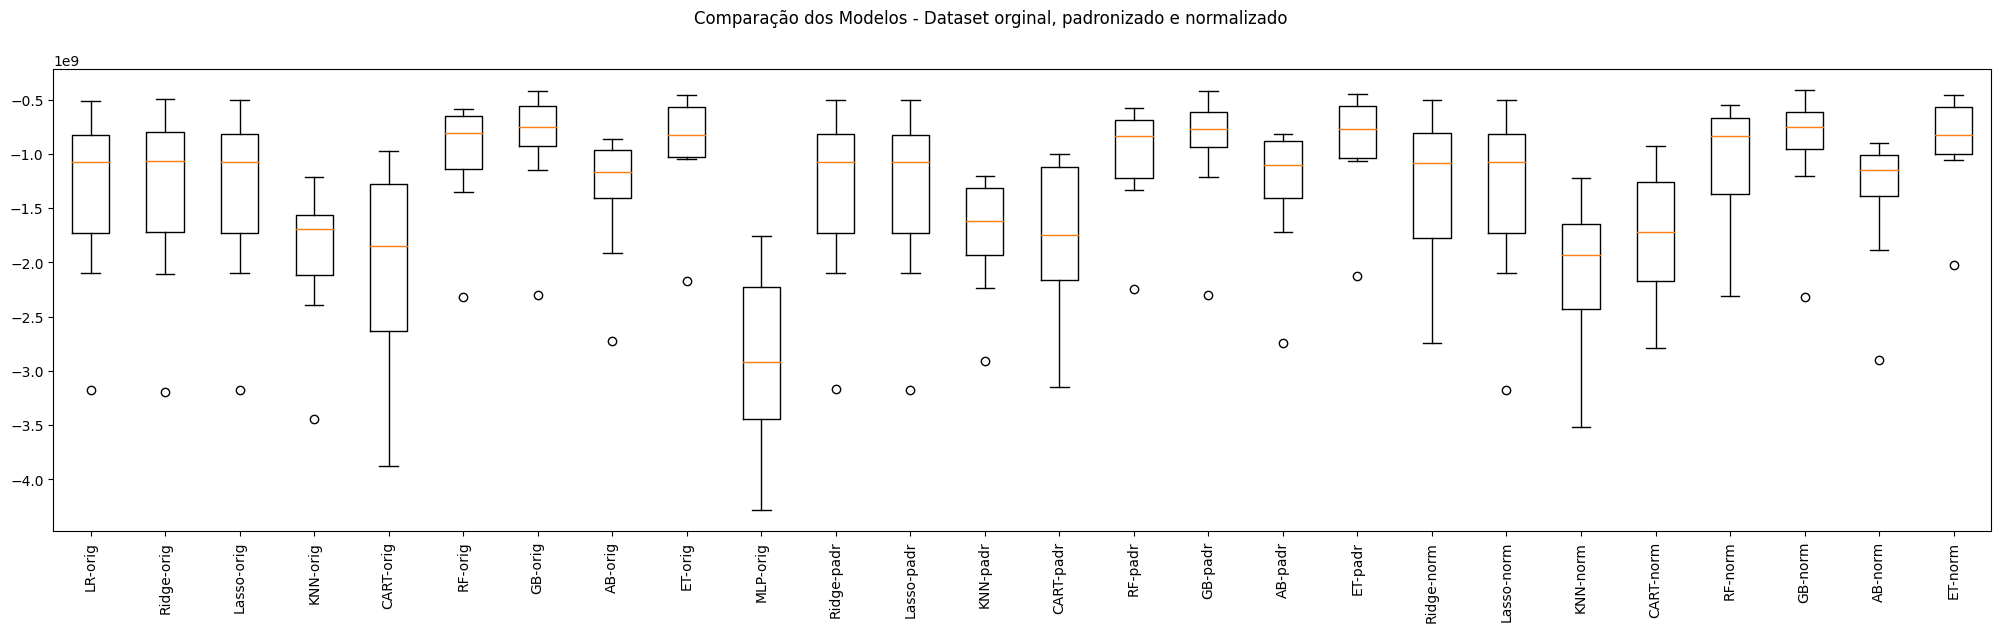

In [23]:
np.random.seed(42) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
lin_reg = ('LR', LinearRegression())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
knn = ('KNN', KNeighborsRegressor())
decision_tree = ('CART', DecisionTreeRegressor())
svr = ('SVM', SVR())
random_forest = ('RF', RandomForestRegressor())
gradient_boost = ('GB', GradientBoostingRegressor())
ada_boost= ('AB', AdaBoostRegressor())
extra_trees= ('ET', ExtraTreesRegressor())
multi_layer_perceptron= ('MLP', MLPRegressor())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([lin_reg])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([decision_tree])))
#pipelines.append(('SVM-orig', Pipeline([svr]))) SVM foi removido pois errou por muito as previsões atrapalhando a visualização gráfica dos resultados
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('GB-orig', Pipeline([gradient_boost])))
pipelines.append(('AB-orig', Pipeline([ada_boost])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('MLP-orig', Pipeline([multi_layer_perceptron])))

# Dataset Padronizado
#pipelines.append(('LR-padr', Pipeline([standard_scaler, lin_reg]))) LR-padr foi removido pois errou por muito as previsões
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, decision_tree])))
#pipelines.append(('SVM-padr', Pipeline([standard_scaler, svr]))) SVM-padr foi removido pois errou por muito as previsões
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boost])))
pipelines.append(('AB-padr', Pipeline([standard_scaler, ada_boost])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
#pipelines.append(('MLP-padr', Pipeline([standard_scaler, multi_layer_perceptron]))) MLP-padr foi removido pois errou por muito as previsões

# Dataset Normalizado
#pipelines.append(('LR-norm', Pipeline([min_max_scaler, lin_reg]))) LR-norm foi removido pois errou por muito as previsões
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler, lasso])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, decision_tree])))
#pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svr]))) SVM-norm foi removido pois errou por muito as previsões
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boost])))
pipelines.append(('AB-norm', Pipeline([min_max_scaler, ada_boost])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
#pipelines.append(('MLP-norm', Pipeline([min_max_scaler, multi_layer_perceptron]))) MLP-norm foi removido pois errou por muito as previsões

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error")
    results.append(cv_results)
    names.append(name)
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)


# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Grid search no gradient boost:

In [29]:
# Tuning do GB

np.random.seed(42)

pipelines = []

# Definindo os componentes do pipeline
gradient_boost = ('GB', GradientBoostingRegressor())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('GB-orig', Pipeline(steps=[gradient_boost])))
pipelines.append(('gb-padr', Pipeline(steps=[standard_scaler, gradient_boost])))
#pipelines.append(('gb-norm', Pipeline(steps=[min_max_scaler, gradient_boost])))

param_grid = {
    "GB__n_estimators":[ 1000, 2000, 4000],
    "GB__learning_rate": [0.01, 0.1],
    "GB__subsample": [0.3, 0.5, 0.7],
    "GB__max_depth": [1, 3, 5]
    }


# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=kfold)
    grid.fit(X_train, y_train)

    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, np.sqrt(abs(grid.best_score_)), grid.best_params_))

GB-orig - Melhor: 28625.285909 usando {'GB__learning_rate': 0.01, 'GB__max_depth': 3, 'GB__n_estimators': 2000, 'GB__subsample': 0.7}
gb-padr - Melhor: 28658.842937 usando {'GB__learning_rate': 0.01, 'GB__max_depth': 3, 'GB__n_estimators': 2000, 'GB__subsample': 0.7}


No grid search acima, a abrangência dos hiperparâmetros foi reajustada sempre que o melhor resultado era encontrado em algum valor na ponta (exemplo: [ponta, x, y, z, ponta]).

Utilizar uma variação muito grande de hiperparâmetros era inviável pois o treinamento demorava tempo demais.

A versão 'gb-norm' foi excluída do GridSearchCV pois após algumas execuções deste constatou-se que a versão normalizada nunca era melhor que a original ou a padronizada, e acabava aumentando significativamente o tempo de execução da célula.


O conjunto completo de configurações testadas de hiperparâmetros foi:

GB__n_estimators:[10, 50, 100, 500, 1000, 2000]

GB__learning_rate: [0.0001, 0.001, 0.01, 0.1, 1.0]

GB__subsample: [0.3, 0.5, 0.7, 1.0]

GB__max_depth: [1, 3, 7, 9]



In [30]:
# O melhor modeloGridSearchCV
best_model = grid.best_estimator_

## Resultado

In [31]:
y_pred = best_model.predict(X_test)

In [109]:
print("A média do target nos valores de teste é", round(y_test.mean()), "contra", round(y_train.mean()), "do grupo de treino.")
print("O erro absoluto do teste ficou em", round(mean_absolute_error(y_test, y_pred)), "contra 28658 do treino.")

A média do target nos valores de teste é 179175 contra 187606 do grupo de treino.
O erro absoluto do teste ficou em 18372 contra 28658 do treino.


Ou seja, o modelo performou melhor no teste que no treino.

Abaixo prepararemos os dados para organizar a visualização dos dados de previsão do modelo na base de teste.

In [133]:
df_test_prev = pd.DataFrame()
df_test_prev['test'] = pd.DataFrame(y_test)
df_test_prev['prev'] = y_pred

df_test_prev_sorted = df_test_prev.sort_values(by='test')
df_test_prev_sorted = df_test_prev_sorted.reset_index(drop=False)

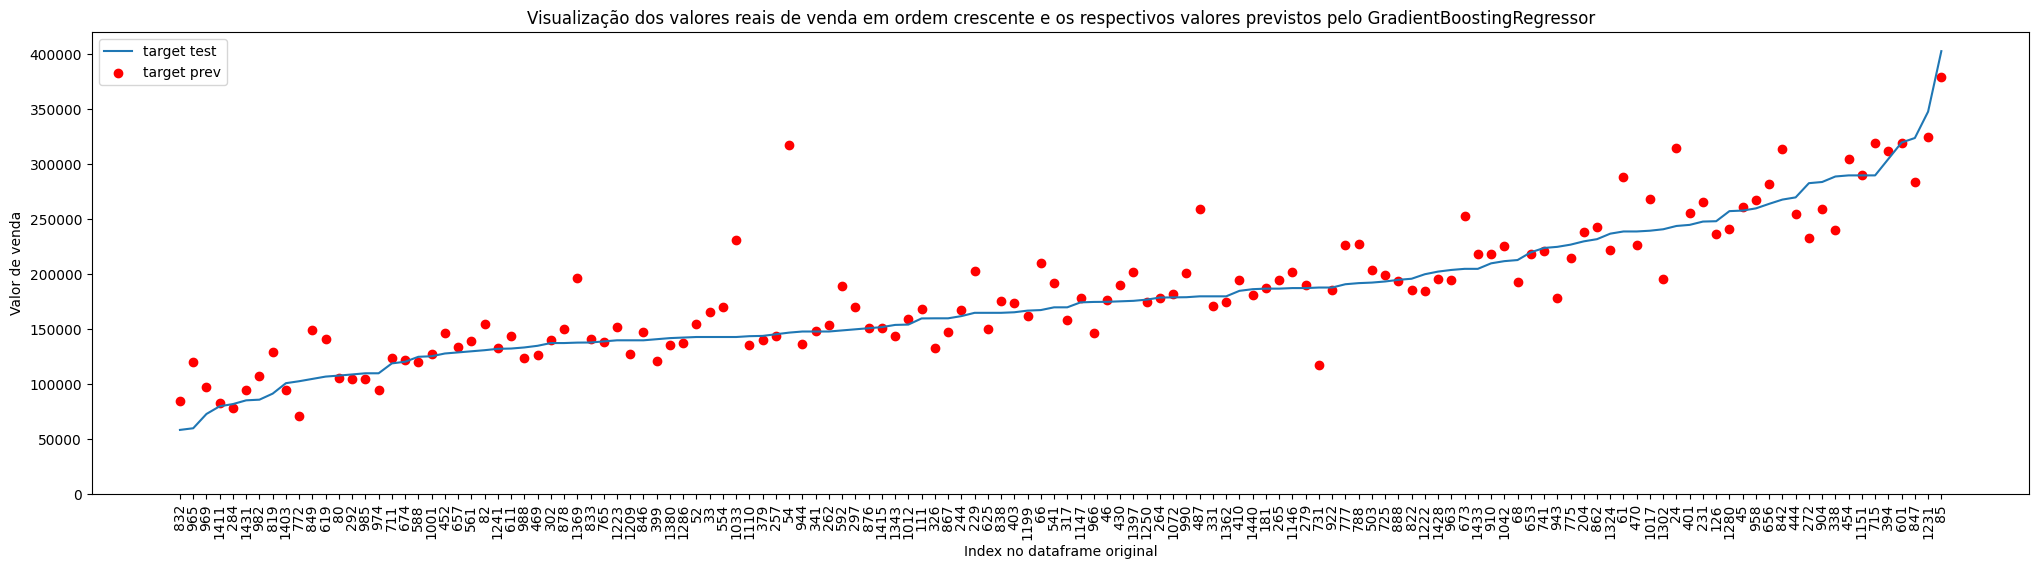

In [147]:
fig = plt.figure(figsize=(25,6))

# Plotar a coluna 'test' como linha e a coluna 'prev' como pontos
plt.plot(df_test_prev_sorted.index, df_test_prev_sorted['test'], label='target test')
plt.scatter(df_test_prev_sorted.index, df_test_prev_sorted['prev'], color='red', label='target prev')

plt.legend() # Adicionar legenda
plt.xlabel('Index no dataframe original') # Adiciona label ao eixo x
plt.ylabel('Valor de venda') # Adiciona label ao eixo y
plt.title('Visualização dos valores reais de venda em ordem crescente e os respectivos valores previstos pelo GradientBoostingRegressor') # Adicionar um título ao gráfico
plt.xticks(df_test_prev_sorted.index, df_test_prev.index, rotation=90) # Definir o índice como rótulos nominais no eixo x
plt.ylim(0) # Definir o limite mínimo do eixo y para 0
plt.show() # Exibir o gráfico

Conclusão:

Ao analisar o resultado do modelo, devemos levar em consideração que o valor de venda de um imóvel é parcialmente subjetivo, ou seja, depende da avaliação pessoal de valor de quem vende e quem compra. Dito isso, era de se esperar alguma dispersão entre o valor de venda real e o previsto, e que o algoritmo funcionasse como uma referência de tendência do preço. Podemos ver no gráfico postado acima que os valores previstos orbitam próximo ao valor real, como desejado, e que a dispersão média fica próxima de 10%, indicando um bom desempenho.

# Modelo 2: Deep Learning

O dataset foi extraído do [Kaggle](https://www.kaggle.com/datasets/arnabchaki/tripadvisor-reviews-2023) e consiste em quase 150 mil reviews retiradas do Tripadvisor.

O objetivo deste notebook será tentar criar um modelo de deep learning capaz de adivinhar a nota(rating) de 1 a 5 do review com base no texto deste.

Existe certa subjetividade nesta tarefa, como reviews idênticas receberem notas diferentes por questões pessoais de cada usuário, portanto será analisado não somente a precisão de acertos, como também a proximidade da nota prevista com a nota de fato. Para tal, serão utilizadas as métricas de **accuracy** e **MeanSquaredError**.


## Análise e tratamento dos dados

In [150]:
#df = pd.read_csv('/content/drive/MyDrive/PÓS CD E IA/MVP ML e IA/New_Delhi_reviews.csv', dtype = {'rating_review': float, 'review_full': str})
df = pd.read_csv('https://github.com/dankrelium/Pos-Graduacao/releases/download/New_Delhi_reviews/New_Delhi_reviews.csv', dtype = {'rating_review': float, 'review_full': str})

In [151]:
df.head()

,rating_review,review_full
0,5.0,"Totally in love with the Auro of the place, re..."
1,5.0,I went this bar 8 days regularly with my husba...
2,5.0,We were few friends and was a birthday celebra...
3,5.0,Fatjar Cafe and Market is the perfect place fo...
4,5.0,"Hey Guys, if you are craving for pizza and sea..."


In [152]:
df = df.dropna() # exclui registros sem avaliação escrita ou nota

In [153]:
df.isnull().any() # Verifica se há valores nulos

rating_review    False
review_full      False
dtype: bool

In [154]:
df.shape

(147579, 2)

In [155]:
df.dtypes

rating_review    float64
review_full       object
dtype: object

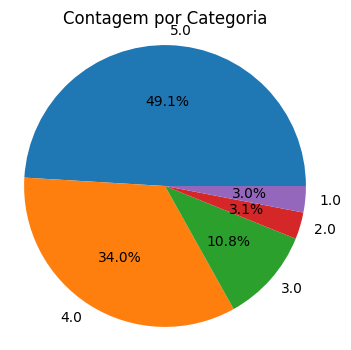

In [156]:
# Agrupar e contar o número de ocorrências por categoria
counts = df['rating_review'].value_counts()

# Plotar o gráfico de pizza
plt.figure(figsize=(4, 4))  # Define o tamanho da figura
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.axis('equal')  # Para criar um círculo perfeito
plt.title('Contagem por Categoria')
plt.show()

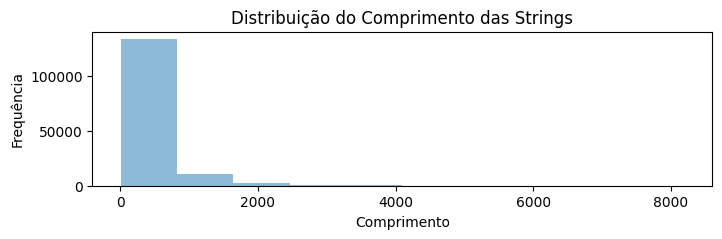

In [157]:
plt.figure(figsize=(8, 2))
plt.hist(df['review_full'].str.len(), bins=10, alpha=0.5)
plt.xlabel('Comprimento')
plt.ylabel('Frequência')
plt.title('Distribuição do Comprimento das Strings')
plt.show()

Excluiremos os registros cujos reviews possuem mais de 2000 caracteres para reduzir o uso de GPU, memória e tempo de processamento.

In [158]:
df = df[df['review_full'].str.len() <= 2000]

In [159]:
df.shape

(145409, 2)

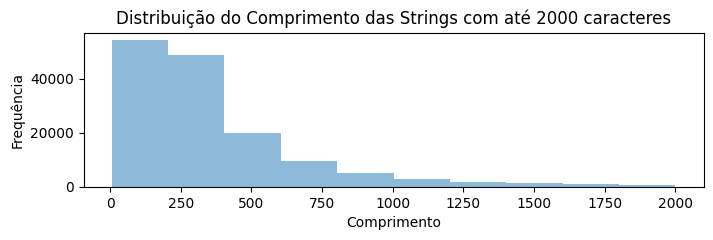

In [160]:
plt.figure(figsize=(8, 2))
plt.hist(df['review_full'].str.len(), bins=10, alpha=0.5)
plt.xlabel('Comprimento')
plt.ylabel('Frequência')
plt.title('Distribuição do Comprimento das Strings com até 2000 caracteres')
plt.show()

Data Cleaning:

In [161]:
def limpar_texto(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'[^a-zA-ZÀ-ú\s]', '', text.lower()) # Remove caracteres especiais e passa o texto para caixa baixa
    tokens = text.split() # Tokenização
    tokens = [token for token in tokens if not token.isdigit()] # Remove números
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens] # Remove pontuação
    tokens = [token.strip() for token in tokens] # Remove espaço em branco extra
    tokens = [token for token in tokens if len(token) > 2] # Remove palavras com menos de 3 caracteres

    # Redução das palavras ao seu radical
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    cleaned_text = ' '.join(tokens) # Junta os tokens de volta a um texto único
    return cleaned_text

In [162]:
# Cria nova coluna 'texto_limpo' com valores da coluna 'review_full' tratados pela função limpar_texto
df['texto_limpo'] = [limpar_texto(text) for text in df['review_full'].astype(str)]
df.head(3)

,rating_review,review_full,texto_limpo
0,5.0,"Totally in love with the Auro of the place, re...",totally love with the auro the place really be...
1,5.0,I went this bar 8 days regularly with my husba...,went this bar days regularly with husband are ...
2,5.0,We were few friends and was a birthday celebra...,were few friends and was birthday celebration ...


In [163]:
# Tokenização
df['texto_limpo'] = df['texto_limpo'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['texto_limpo'] = df['texto_limpo'].apply(lambda x: [word for word in x if word not in stop_words])

In [164]:
df.head(3)

,rating_review,review_full,texto_limpo
0,5.0,"Totally in love with the Auro of the place, re...","[totally, love, auro, place, really, beautiful..."
1,5.0,I went this bar 8 days regularly with my husba...,"[went, bar, days, regularly, husband, fully, s..."
2,5.0,We were few friends and was a birthday celebra...,"[friends, birthday, celebration, food, good, t..."


In [165]:
df['num_elementos'] = df['texto_limpo'].apply(len) # Contagem de elementos em cada registro
indice_max_elementos = df['num_elementos'].idxmax() # Índice do registro com o maior número de elementos
registro_max_elementos = df.loc[indice_max_elementos, 'texto_limpo'] # Registro com o maior número de elementos

print("O registro com o maior número de elementos é:", registro_max_elementos)
print("Número de elementos:", len(registro_max_elementos))

df = df.drop('num_elementos', axis=1) # Remover a coluna 'num_elementos' se não for mais necessária

O registro com o maior número de elementos é: ['restaurant', 'outer', 'circle', 'next', 'barbeque', 'nation', 'second', 'floor', 'cosy', 'restaurant', 'nice', 'simple', 'decor', 'comfortable', 'seating', 'along', 'soft', 'music', 'playing', 'food', 'drinks', 'drinks', 'one', 'hard', 'drink', 'one', 'beer', 'also', 'juice', 'starting', 'offer', 'bar', 'starters', 'manchow', 'soup', 'one', 'veg', 'non', 'veg', 'manchow', 'well', 'cooked', 'balance', 'taste', 'along', 'order', 'fish', 'orly', 'crispy', 'corns', 'chilli', 'fish', 'chilli', 'mushroom', 'tandoori', 'chicken', 'tikka', 'must', 'try', 'dish', 'fish', 'orly', 'use', 'basa', 'fish', 'ten', 'pieces', 'guess', 'carte', 'menu', 'size', 'seriously', 'loved', 'chilli', 'fish', 'awesome', 'crispy', 'side', 'crunchy', 'sides', 'soft', 'inside', 'also', 'crispy', 'corn', 'nice', 'quantity', 'two', 'people', 'easily', 'enjoy', 'dish', 'starters', 'chilli', 'mushroom', 'frind', 'vegetarian', 'hve', 'take', 'care', 'order', 'chicken', 'tik

In [166]:
textos = df['texto_limpo'].astype(str).tolist()
rotulos = df['rating_review'].tolist()

X_treino, X_teste, y_treino, y_teste = train_test_split(textos, rotulos, test_size=0.1, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_treino)
X_treino = tokenizer.texts_to_sequences(X_treino)
X_teste = tokenizer.texts_to_sequences(X_teste)

max_len = 241  # comprimento máximo das sequências
vocab_size = 130000 # comprimento máximo do vocabulário
X_treino = pad_sequences(X_treino, maxlen=max_len)
X_teste = pad_sequences(X_teste, maxlen=max_len)

y_treino = to_categorical(y_treino)
y_teste = to_categorical(y_teste)


In [167]:
vocabulario = set()
for texto in X_treino:
    tokens = str(texto).split()  # quebra o texto em tokens (palavras)
    vocabulario.update(set(tokens))  # adiciona os tokens ao vocabulário
tamanho_vocabulario = len(vocabulario)
print("O tamanho do vocabulário é:", tamanho_vocabulario)

O tamanho do vocabulário é: 125059


## Modelagem

O modelo foi construído tendo como referência o modelo de classificação de texto multicategórico do [Tensorflow](https://www.tensorflow.org/tutorials/keras/text_classification?hl=pt-br).

No desenvolvimento do modelo foram testados:

 - Layers **LSTM** e **Bidirecional(LSTM)**, inspirados no modelo [BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=pt-br) do tensorflow, cujo objetivo seria capturar sequências de palavras como fatores determinantes para o rating do usuário.

 - Layer convolucional de 1 dimensão (**Conv1D**), que apesar de não constar na documentação do tensorflow para o problema em questão, foram encontradas diversas refências de uso na web.

A utilização dos layers citados acima não melhoraram as métricas de treinamento. No bloco de código foram deixados #exemplos de suas utilizações para consulta caso desejado. As camadas de memória aumentaram a demanda por GPU e RAM substancialmente.

 - **Dropout** e **regularização L1/L2**, cujo objetivo era diminuir overfitting e melhorar a generalização. Na prática ambos os métodos alteraram as dinâmicas de aprendizado, mas foram incapazes de melhorar os resultados.

Todas as abordagens listadas foram testadas em diversas configurações de hiperparâmetros e combinadas entre si.

O modelo final escolhido foi testato com diversas camadas ocultas e quantidade de neurônios variados.

Todas essas variações tiveram seus melhores resultados convergindo para o mesmo desempenho, então foi escolhida a versão mais simples e rápida.


As métricas de avaliação escolhidas foram:
- **accuracy** para medir a quantidade de acertos de classificação.
- **MeanSquaredError** para medir a distância média entre as previsões e os valores reais. O objetivo desta métrica é determinar se o modelo ainda está melhorando no caso da **accuracy** permanecer constante,  ou seja, se os erros estão convergindo para acerto.

In [168]:
np.random.seed(42)

# Cria o modelo
modelo_1 = Sequential()
modelo_1.add(Embedding(vocab_size, 12)) # Adiciona uma camada de embedding para representação vetorial das palavras.
modelo_1.add(GlobalAveragePooling1D()) # Retorna um vetor de saída com comprimento fixo
modelo_1.add(Dense(12, activation='relu')) # Camada oculta
modelo_1.add(Dense(6, activation='softmax')) # Adiciona uma camada densa de saída para classificação / ativação softmax é geralmente usada para problemas de classificação com mais de duas classes.
modelo_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "MeanSquaredError"]) # Compila o modelo /'categorical_crossentropy' é usada para problemas de classificação multicategórica.
modelo_1.summary() # Resume o modelo

#modelo_n.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.01), dropout=0.2)))
#modelo_n.add(Dense(32, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
#modelo_n.add(Dropout(0.2))

# Treina o modelo
historico_1 = modelo_1.fit(X_treino, y_treino, batch_size=512, epochs=100, validation_data=(X_teste, y_teste), callbacks=[EarlyStopping(monitor='val_mean_squared_error', patience=5, restore_best_weights=True)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 12)          1560000   
                                                                 
 global_average_pooling1d (G  (None, 12)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
Total params: 1,560,234
Trainable params: 1,560,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
256/256 [==============================] - 55s 196ms/step - loss: 1.3701 - accuracy: 0.4861 - mean_s

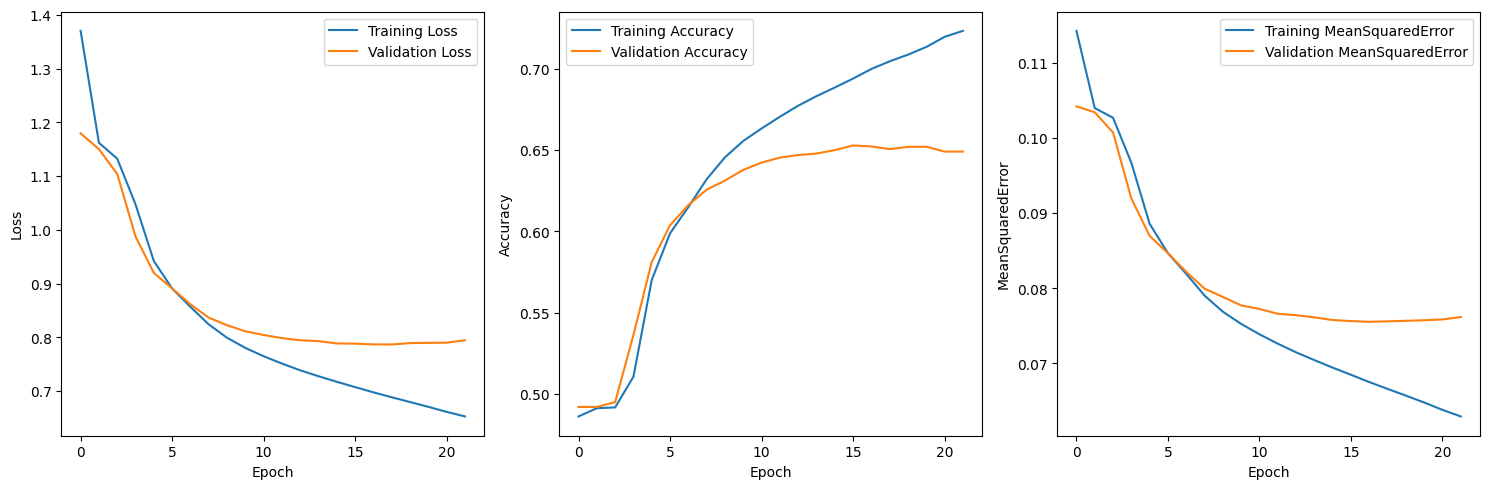

In [169]:
# Extrair as métricas de treinamento e validação
loss = historico_1.history['loss']
val_loss = historico_1.history['val_loss']
accuracy = historico_1.history['accuracy']
val_accuracy = historico_1.history['val_accuracy']
MSE = historico_1.history['mean_squared_error']
val_MSE = historico_1.history['val_mean_squared_error']

# Criar a figura com três subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotar a curva de perda
axs[0].plot(loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotar a curva de precisão
axs[1].plot(accuracy, label='Training Accuracy')
axs[1].plot(val_accuracy, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plotar a curva de MSE
axs[2].plot(MSE, label='Training MeanSquaredError')
axs[2].plot(val_MSE, label='Validation MeanSquaredError')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('MeanSquaredError')
axs[2].legend()

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir a figura
plt.show()

As curvas de Loss, Accuracy e MeanSquaredError tiveram o comportamento esperado do aprendizado.

In [170]:
# Fazer previsões com o conjunto de teste
previsoes = modelo_1.predict(X_teste)
previsoes_classes = np.argmax(previsoes, axis=1)

# Avaliar o desempenho do modelo
resultado = modelo_1.evaluate(X_teste, y_teste)

# Resultado contém a perda e as métricas calculadas durante a avaliação
loss = resultado[0]
accuracy = resultado[1]

455/455 [==============================] - 1s 3ms/step - loss: 0.7868 - accuracy: 0.6524 - mean_squared_error: 0.0755


## Resultado

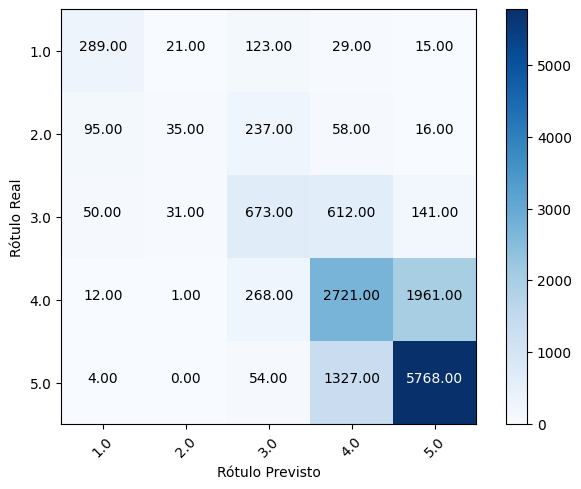

In [171]:
cm = confusion_matrix(np.argmax(y_teste, axis=1), previsoes_classes)

# Função auxiliar para plotar a matriz de confusão
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo Real')
    plt.xlabel('Rótulo Previsto')

# Plotando a matriz de confusão
plot_confusion_matrix(cm, [1., 2., 3., 4., 5.])
plt.show()

A matriz confusão demonstra que o modelo alcançou um bom resultado, pois os maiores valores se concentram na diagonal principal e vão diminuindo gradativamente conforme se distanciam desta.

In [172]:
# Acurácia
accuracy = accuracy_score(np.argmax(y_teste, axis=1), previsoes_classes)
print("Acurácia:", accuracy)

# Relatório de Classificação
target_names = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']
classification_rep = classification_report(np.argmax(y_teste, axis=1), previsoes_classes, target_names=target_names)
print("Relatório de Classificação:")
print(classification_rep)

Acurácia: 0.6523622859500722
Relatório de Classificação:
              precision    recall  f1-score   support

    Rating 1       0.64      0.61      0.62       477
    Rating 2       0.40      0.08      0.13       441
    Rating 3       0.50      0.45      0.47      1507
    Rating 4       0.57      0.55      0.56      4963
    Rating 5       0.73      0.81      0.77      7153

    accuracy                           0.65     14541
   macro avg       0.57      0.50      0.51     14541
weighted avg       0.64      0.65      0.64     14541



O Relatório de Classificação reitera o bom desempenho geral do modelo, principalmente nos rating extremos 1 e 5.

Também fica evidente uma maior dificuldade em classificar especificamente o rating 2.

Análise dos piores erros de classificação:

In [173]:
# Selecionando registros com rótulo real igual a 5 e rótulo previsto igual a 1
indices_selecionados = np.where((np.argmax(y_teste, axis=1) == 5) & (previsoes_classes == 1))[0]

print("Rótulo Real: 5  /  Rótulo Previsto: 1 \n")
# Iterando sobre os registros selecionados e imprimindo as informações
for indice in indices_selecionados:
    print("Registro ", indice, " Review: ", df.iloc[indice, 1])

Rótulo Real: 5  /  Rótulo Previsto: 1 

Registro  2464  Review:  It is a great restaurant. Mr Sumit Kumar miss Radha served us very well. Great place, great experience. Must visit. 
Registro  5481  Review:  Good restaurant for Indian food great prompt service nice rasmalai cake will recommend all family and friends. Thanks for delightful evenings.
Registro  7810  Review:  hard rock cafe provides excellent service with friendly staff . Everything that you order would taste delicious. highly recommended.
Registro  8912  Review:  Was invited by my friend for a dinner. Had an extremely authentic and flavourful experience of chinese and thai food


In [174]:
# Selecionando registros com rótulo real igual a 5 e rótulo previsto igual a 1
indices_selecionados = np.where((np.argmax(y_teste, axis=1) == 1) & (previsoes_classes == 5))[0]

print("Rótulo Real: 1  /  Rótulo Previsto: 5 \n")
# Iterando sobre os registros selecionados e imprimindo as informações
for indice in indices_selecionados:
    print("Registro ", indice, " Review: ", df.iloc[indice, 1])

Rótulo Real: 1  /  Rótulo Previsto: 5 

Registro  1948  Review:  Excellent food, mutton rogan josh was amazing, best in class service (Shivam was exceptional and kind)and live music.. had a great time.
Registro  2126  Review:  Visited for a quick get together with friends, was not disappointed at all. The selection of food and drinks is world class. Topesh and his team is very friendly. Will be back soon..
Registro  2951  Review:  Best food in West Delhi . Good service , great salad bar , excellent deserts and a wide variety of wine .
Registro  3299  Review:  Went their to celebrate my friend's birthday. We'd thier pizza and potato wedges . Pizza was very good the potato wedges could be better .🤗 Overall good experience 👍
Registro  3877  Review:  Fantastic buffet choice on the day of my visit. Huge choice of international and Indian cuisine. Pleasent setting. Nice staff
Registro  4544  Review:  Veda has beautiful combination of baroque interiors and authentique indian cuisine. Try the 

**Real: 5  / Previsto: 1** - Nesse extremo podemos ver que o modelo ainda pode ser melhorado pois ocorrem 6 casos em que as reviews são explicitamente boas, porém classificadas como ruins.

**Real: 1 / Previsto:** 5 - Neste outro extremo observamos algo interessante: As 30 reviews são boas e o modelo as classifica como tal, porém review e rating são contraditórios. Possivelmente o usuário clicou errado ou pensou que a classificação 1 fosse a melhor.

## Conclusão:

Levando em consideração todos os aspectos descritos na construção do projeto e nas análises de resultado, conclui-se que o modelo atingiu bons resultados. O projeto em si representou um desafio no âmbito exploratório e executivo especialmente por se tratar de uma classificação multi-categórica ordinal, enquanto outros projetos similares encontrados como referência tratavam de classificação multi-categórica nominal ou classificação binária.